In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_dir = r"dataset/ImageEmotion (85-15)/train"
test_dir = r"dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [7]:
#loading image data
train_imagedata_preprocessed = np.load(r'FeatureFiles/ResNet_train_imagedata_preprocessed.npy', mmap_mode='r')
print('Loaded train image data preprocessed')
test_imagedata_preprocessed = np.load(r'FeatureFiles/ResNet_test_imagedata_preprocessed.npy', mmap_mode='r')
print('Loaded test image data preprocessed')
train_lowfeatures = np.load(r'FeatureFiles/train_lowfeatures.npy')
print('Loaded train low features')
test_lowfeatures = np.load(r'FeatureFiles/test_lowfeatures.npy')
print('Loaded test low features')
train_semanticfeatures = np.load(r'FeatureFiles/train_semanticfeatures_normalized.npy')
print('Loaded train semantic features.')
test_semanticfeatures = np.load(r'FeatureFiles/test_semanticfeatures_normalized.npy')
print('Loaded test semantic features')

train_labels = np.load(r'FeatureFiles/train_labels.npy')
print('Loaded train labels')
test_labels = np.load(r'FeatureFiles/test_labels.npy')
print('Loaded test labels')

Loaded train image data preprocessed
Loaded test image data preprocessed
Loaded train low features
Loaded test low features
Loaded train semantic features.
Loaded test semantic features
Loaded train labels
Loaded test labels


In [8]:
train_data = tf.data.Dataset.from_tensor_slices(((train_semanticfeatures,train_imagedata_preprocessed,
                                                  train_lowfeatures), train_labels))
test_data = tf.data.Dataset.from_tensor_slices(((test_semanticfeatures,test_imagedata_preprocessed,
                                                test_lowfeatures), test_labels))

train_data = train_data.batch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE)

In [17]:
def Load_Model(modelpath_json, weights_path):
    
    #loading the model
    json_file = open(modelpath_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    
    model = loaded_model
    clear_output()
    
    return model

In [15]:
basee_model = tf.keras.applications.resnet.ResNet101(input_shape=(224,224,3), include_top=False,
                                                weights= 'imagenet')

def base_model_feature_extractor(inputs):
    y = basee_model(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def classifier(features):
#     x = tf.keras.layers.Dense(1500, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.001))(features)
#     x = tf.keras.layers.Dense(500, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
#     x = tf.keras.layers.Dense(100, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              #kernel_regularizer= tf.keras.regularizers.l2(0.01),
                              name='classification')(features)
    
    return x
        
def final_model(inputs1, inputs2, inputs3, base_model):
    x, CNN_features = base_model(inputs2)
    merged_features = tf.concat([inputs1, CNN_features, inputs3], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output

def define_compile_model(baseweights_path):
    
    inputs1 = tf.keras.layers.Input(shape=(151,))
    inputs2 = tf.keras.layers.Input(shape=(224,224,3))
    inputs3 = tf.keras.layers.Input(shape=(9,))
    #base_model = Load_Model(basemodel_path, baseweights_path)
    base_model = tf.keras.Model(inputs= inputs2, outputs= base_model_feature_extractor(inputs2))
    base_model.load_weights(baseweights_path)
    #base_model.layers[-1].trainable = False
    classification_output = final_model(inputs1, inputs2, inputs3, base_model) 
    model = tf.keras.Model(inputs= [inputs1,inputs2,inputs3], outputs= classification_output)
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [16]:
baseweights_path = r'h5 files/ResNet101-009-0.762864-0.650595.h5'
#basemodel_path = r'json files/MobileNetV2_(7,7,1280).json'
model = define_compile_model(baseweights_path)
#model.load_weights(r'MobileNetV2_CNN+Sem+LF-004-0.691902-0.577052.h5')

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_11 (InputLayer)          [(None, 151)]        0           []                               
                                                                                                  
 model_3 (Functional)           ((None, 8),          42674568    ['input_12[0][0]']               
                                 (None, 2048))                                                    
                                                                                            

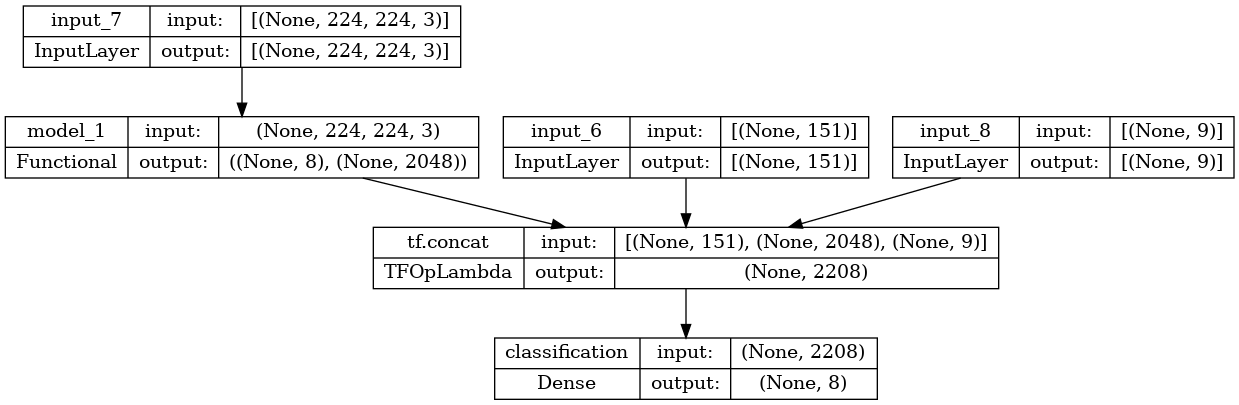

In [13]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [17]:
#for saving weights after every epoch
checkpoint = ModelCheckpoint('Idea1_ResNet101-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, 
                        monitor='val_acc',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [18]:
#training the model
history = model.fit(train_data,
            batch_size = BATCH_SIZE,
            epochs= 300,
            validation_data = test_data,
            callbacks= [checkpoint]
            )

history = pd.DataFrame(history.history)

Epoch 1/300
290/290 [==============================] - ETA: 0s - loss: 1.5026 - acc: 0.4744
Epoch 1: val_acc improved from -inf to 0.54287, saving model to Idea1_ResNet101-001-0.474433-0.542875.h5
290/290 [==============================] - 1807s 6s/step - loss: 1.5026 - acc: 0.4744 - val_loss: 1.3326 - val_acc: 0.5429
Epoch 2/300
290/290 [==============================] - ETA: 0s - loss: 1.1007 - acc: 0.6178
Epoch 2: val_acc improved from 0.54287 to 0.57705, saving model to Idea1_ResNet101-002-0.617813-0.577052.h5
290/290 [==============================] - 1796s 6s/step - loss: 1.1007 - acc: 0.6178 - val_loss: 1.2274 - val_acc: 0.5771
Epoch 3/300
290/290 [==============================] - ETA: 0s - loss: 0.9536 - acc: 0.6703
Epoch 3: val_acc improved from 0.57705 to 0.59292, saving model to Idea1_ResNet101-003-0.670295-0.592920.h5
290/290 [==============================] - 1795s 6s/step - loss: 0.9536 - acc: 0.6703 - val_loss: 1.1840 - val_acc: 0.5929
Epoch 4/300
290/290 [=============

KeyboardInterrupt: 

In [ ]:
#plotting accuracy vs epochs
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs_mobilenet_60dl_low100_bs32_lesscmplx_lr0.0001',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [23]:
#saving the  model to be used later
fer_json = model.to_json()
with open("MobileNetV2_CNN+Sem+LF.json", "w") as json_file:
    json_file.write(fer_json)
#model.save_weights("VGG16_512.h5") #make sure to rename this file after each 100 epochs
print("Saved model somewhere")

Saved model somewhere
